In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using JLD2, FileIO
include("HyperECNNs.jl")
rng = MersenneTwister(1234);

In [2]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2bin(x,Nbits=8)
    y = Array{Int64}(undef,length(x),Nbits)
    for i=1:length(x)
        y[i,:] = 2*digits(x[i], base=2, pad = Nbits).-1
    end
    return y, size(x)
end

function bin2gray(y, xsize)
    return reshape([Int(sum(((y[i,:].+1)/2).*2 .^(0:size(y,2)-1))) for i=1:size(y,1)],xsize)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

function gray2multistate(x,K)
    zsize = size(x)
    z = exp.(2.0*pi*x*im/K)[:]
    return hcat(real.(z),imag.(z)), zsize
end

function multistate2gray(y,K,ysize)
    z = y[:,1]+y[:,2]*im
    return reshape(Array{Int64}((round.(K*(2*pi.+angle.(z))./(2*pi))).%K),ysize)
end

function gray2multistateC(x,K)
    return exp.(2.0*pi*x*im/K)
end

function multistate2grayC(y,K)
    return Array{Int64}((round.(K*(2*pi.+angle.(y))./(2*pi))).%K)
end

function gray2TwinMultistate(x,K)
    zbin,zsize = gray2bin(x,8)
    c1 = gray2multistateC(bin2gray(zbin[:,1:4],zsize),K)
    c2 = gray2multistateC(bin2gray(zbin[:,5:8],zsize),K)
    return hcat(real.(c1)[:],imag.(c1)[:],real.(c2)[:],imag.(c2)[:]), zsize
end

function TwinMultistate2gray(xc,K,xsize)
    c1, csize = gray2bin(multistate2grayC(xc[:,1]+xc[:,2]*im,K),4)
    c2, csize = gray2bin(multistate2grayC(xc[:,3]+xc[:,4]*im,K),4)
    return bin2gray(hcat(c1,c2),xsize)
end

TwinMultistate2gray (generic function with 1 method)

In [3]:
# load full training set
train_x, train_y = CIFAR10.traindata();

In [4]:
# Select the fundamental memory
P = 200
indFM = randperm(rng, size(train_x)[4])[1:P];

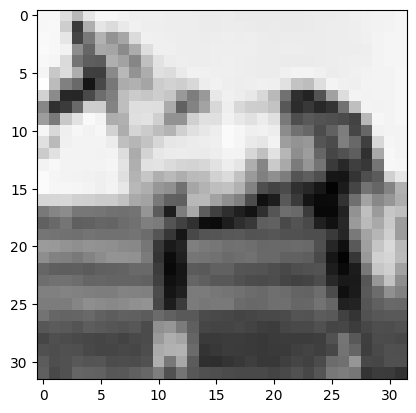

In [5]:
# Select one image from the fundamental memory set
iFMS=200
imgx = cifar2gray(train_x[:,:,:,indFM[iFMS]])
imshow(transpose(imgx),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Original (undistorted) image")
savefig("Figures/CIFAR_Original.eps", bbox_inches="tight")
savefig("Figures/CIFAR_Original.pdf", bbox_inches="tight")

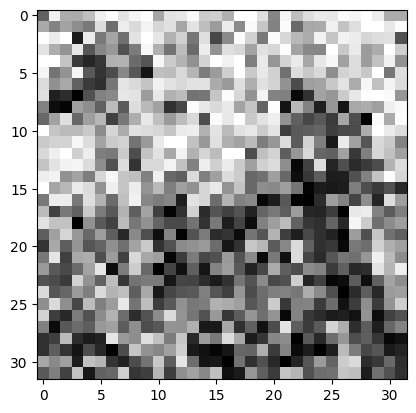

In [6]:
imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[iFMS]],100/255))
imshow(transpose(imgxr),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Corrupted image")
savefig("Figures/CIFAR_Corrupted.eps", bbox_inches="tight")
savefig("Figures/CIFAR_Corrupted.pdf", bbox_inches="tight")

  1.334445 seconds (3.85 M allocations: 301.724 MiB, 7.01% gc time)


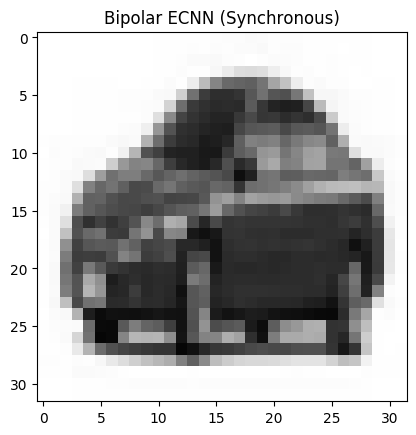

MSE = 34.85701471166708

PyObject Text(0.5, 1, 'Bipolar ECNN (Synchronous)')

In [7]:
# Bipolar ECNN

N = 8*(32*32)
alpha = 20/N
beta = -20

U = Array{Int64}(undef,N,1,P)
for i=1:P
    ubin, xsize = gray2bin(cifar2gray(train_x[:,:,:,indFM[i]]))
    U[:,1,i] = ubin[:]
end

x, xsize = gray2bin(imgxr)
@time y, Energy = HyperECNNs.Sync(HyperECNNs.LambdaInner,[1],HyperECNNs.SplitSign,nothing,U,reshape(x,8*1024,1),alpha,beta)
imgy = bin2gray(reshape(y,(1024,8)),xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Bipolar ECNN (Synchronous)")

  0.754291 seconds (2.22 M allocations: 570.816 MiB, 11.36% gc time)


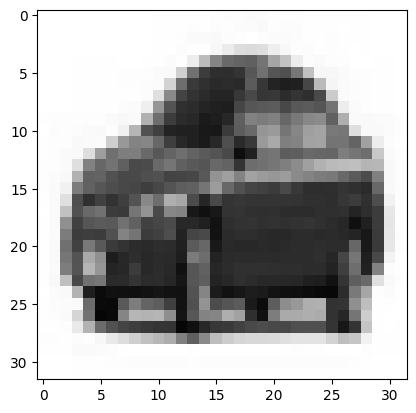

MSE = 34.85701471166708

In [8]:
@time y, Energy = HyperECNNs.Seq(HyperECNNs.LambdaInner,[1],HyperECNNs.SplitSign,nothing,U,reshape(x,8*1024,1),alpha,beta)
imgy = bin2gray(reshape(y,(1024,8)),xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Bipolar ECNN (Asynchronous)")

savefig("Figures/CIFAR_BipolarECNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_BipolarECNN.pdf", bbox_inches="tight")

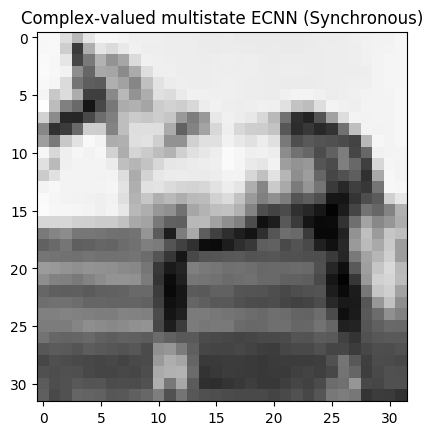

  1.222277 seconds (8.68 M allocations: 256.003 MiB, 7.16% gc time)
MSE = 0.0

PyObject Text(0.5, 1, 'Complex-valued multistate ECNN (Synchronous)')

In [9]:
# Complex-valued Multistate ECNN

N = 32*32
K = 256
alpha = 20/N
beta = -20

U = Array{Real}(undef,N,2,P)
for i=1:P
    uc, usize = gray2multistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
    U[:,:,i] = uc
end

x, xsize = gray2multistate(imgxr,K)
@time y, Energy = HyperECNNs.Sync(HyperECNNs.LambdaInner,[1,1],HyperECNNs.csign,K,U,x,alpha,beta)

imgy = multistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Complex-valued multistate ECNN (Synchronous)")

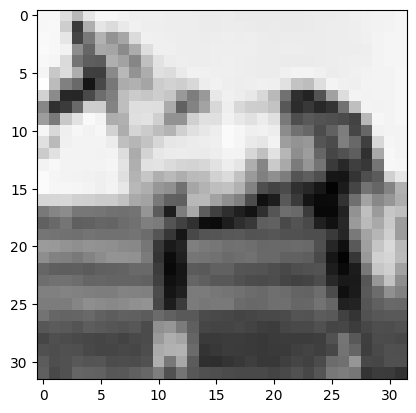

  0.689306 seconds (16.62 M allocations: 388.023 MiB, 6.59% gc time)
MSE = 0.0

In [10]:
@time y, Energy = HyperECNNs.Seq(HyperECNNs.LambdaInner,[1,1],HyperECNNs.csign,K,U,x,alpha,beta)

imgy = multistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Complex-valued multistate ECNN (Asynchronous)")

savefig("Figures/CIFAR_CvMultistateECNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_CvMultistateECNN.pdf", bbox_inches="tight")

  0.311467 seconds (11.75 M allocations: 231.675 MiB, 11.09% gc time)


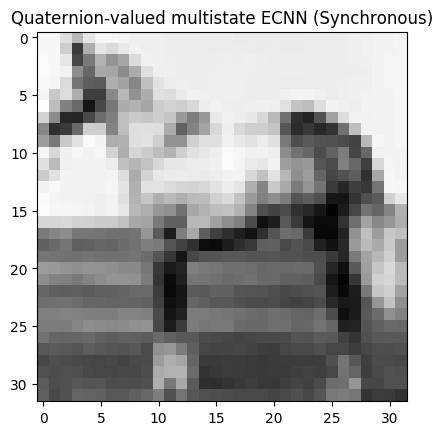

MSE = 0.0

PyObject Text(0.5, 1, 'Quaternion-valued multistate ECNN (Synchronous)')

In [11]:
# Quaternion Multistate ECNN

N = 32*32
K = 16
alpha = 20/(2*N)
beta = -20

U = Array{Real}(undef,N,4,P)
for i=1:P
    uc, usize = gray2TwinMultistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
    U[:,:,i] = uc
end

x, xsize = gray2TwinMultistate(imgxr,K)
@time y, Energy = HyperECNNs.Sync(HyperECNNs.LambdaInner,[1,1,1,1],HyperECNNs.twincsign,16,U,x,alpha,beta)
        
imgy = TwinMultistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Quaternion-valued multistate ECNN (Synchronous)")

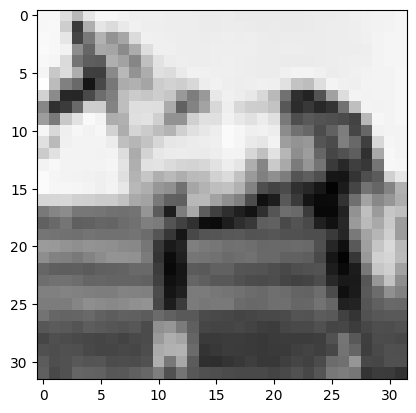

  0.867310 seconds (31.56 M allocations: 678.144 MiB, 6.02% gc time)
MSE = 0.0

In [12]:
@time y, Energy = HyperECNNs.Seq(HyperECNNs.LambdaInner,[1,1,1,1],HyperECNNs.twincsign,16,U,x,alpha,beta)
        
imgy = TwinMultistate2gray(y,K,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Quaternion-valued multistate ECNN (Asynchronous)")

savefig("Figures/CIFAR_QvMultistateECNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_QvMultistateECNN.pdf", bbox_inches="tight")

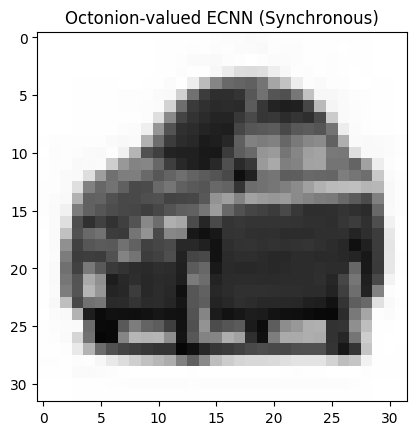

MSE = 98.59052589815616

PyObject Text(0.5, 1, 'Octonion-valued ECNN (Synchronous)')

In [13]:
# Octonion-valied ECNN

N = 32*32
alpha = 20/(8*N)
beta = -20

U = Array{Real}(undef,N,8,P)
for i=1:P
    uc, usize = gray2bin(cifar2gray(train_x[:,:,:,indFM[i]]),8)
    U[:,:,i] = uc
end

x, xsize = gray2bin(imgxr,8)
y, Energy = HyperECNNs.Sync(HyperECNNs.LambdaInner,[1,1,1,1,1,1,1,1],HyperECNNs.SplitSign,nothing,
            U,x,alpha,beta)

imgy = bin2gray(y,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
title("Octonion-valued ECNN (Synchronous)")

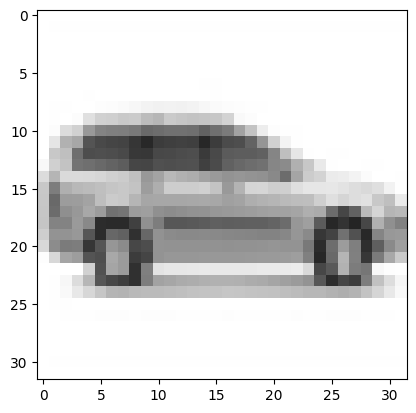

MSE = 112.33826047088766

In [14]:
y, Energy = HyperECNNs.Seq(HyperECNNs.LambdaInner,[1,1,1,1,1,1,1,1],HyperECNNs.SplitSign,nothing,
            U,x,alpha,beta)

imgy = bin2gray(y,xsize)
print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Octonion-valued ECNN (Asynchronous)")

savefig("Figures/CIFAR_OctonionECNN.eps", bbox_inches="tight")
savefig("Figures/CIFAR_OctonionECNN.pdf", bbox_inches="tight")